# ***Replica Who Grade Binary Classification***

This notebook shows the process of classifying replica samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../../../DHG/"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"{DHG_PATH}/models/section/binary_who_grade_classification"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 92000
# The MSI sample type for filtering
SAMPLE_TYPE = "replica"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [3]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

    """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intenisties
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [4]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)

# Filter by sample_type
metadata_df = metadata_df[metadata_df["sample_type"] == SAMPLE_TYPE]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [5]:
# Create dict's to store each sample spectra's mean and std
# for non-tissue spectra's
sample_non_tissue_mean = {}
sample_non_tissue_std = {}

# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(DATA_IN_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Get local TIC image of msi in range [600, 900] (X region)
    local_tic_img = data[:, :, ((mzs > (TRESH_MZ - TRESH_MZ_TOL))) &
                         (mzs < (TRESH_MZ + TRESH_MZ_TOL))].sum(axis=-1)

    # Threshold image to separate tissue spectra from background
    thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)

    # Get non-tissue spectra's mean
    sample_non_tissue_mean[row.sample_file_name
                          ] = data[~thresh_img, :].mean(axis=0)
    # Get non-tissue spectra's std
    sample_non_tissue_std[row.sample_file_name
                         ] = data[~thresh_img, :].std(axis=0)

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Keep sample file name of spectra
      file_names.append(row.sample_file_name)
      # Keep sample number of spectra
      sample_numbers.append(row.sample_number)
      # Keep sample histology of spectra
      histologies.append(row.histology)
      # Keep sample who grade of spectra
      who_grades.append(row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)

# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [01:38<00:00,  4.09s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [6]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [7]:
def map_index(index: tf.Tensor,
              standardize: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.
      standardize (tf.Tensor): flag to determine standardization applying.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  index, standardize = index.numpy(), standardize.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Apply standardization
  if standardize:
    spectra = (
        (spectra - sample_non_tissue_mean[file_name]) /
        sample_non_tissue_std[file_name]
    )

  # Return spectra and label
  return (spectra, labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    indexes: np.ndarray, batch_size: int, standardize: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size
      standardize (bool): flag to determine standardization applying.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(
      lambda i: tf.py_function(
          func=map_index, inp=[i, standardize], Tout=[tf.float32, tf.float32]
      )
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [8]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Approach 1 - Leave one sample out + no standardization:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [9]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, False)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, False)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_1/excluded_{exclude_sample}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
126/126 [==============================] - 45s 350ms/step - loss: 0.0489 - binary_accuracy: 0.9813 - val_loss: 0.6661 - val_binary_accuracy: 0.6165
INFO:tensorflow:Assets written to: .\approach_1/excluded_2\assets
Epoch 2/100
126/126 [==============================] - 47s 369ms/step - loss: 0.0049 - binary_accuracy: 0.9991 - val_loss: 0.5924 - val_binary_accuracy: 0.6236
INFO:tensorflow:Assets written to: .\approach_1/excluded_2\assets
Epoch 3/100
126/126 [==============================] - 45s 352ms/step - loss: 0.0029 - binary_accuracy: 0.9994 - val_loss: 0.5850 - val_binary_accuracy: 0.4330
Epoch 4/100
126/126 [==============================] - 44s 350ms/step - loss: 0.0038 - binary_accuracy: 0.9990 - val_loss: 0.1115 - val_binary_accuracy: 0.9996
INFO:tensorflow:Assets written to: .\approach_1/excluded_2\assets
Epoch 5/100
126/126 [==============================] - 45s 353ms/step - loss: 0.0020 - binary_accuracy: 0.9994 - val_loss: 0.0062 - val_binary_accuracy: 0.9995
Ep

  5%|▍         | 1/22 [13:56<4:52:36, 836.01s/it]

##############################
Epoch 1/100
125/125 [==============================] - 43s 337ms/step - loss: 0.0584 - binary_accuracy: 0.9769 - val_loss: 0.6818 - val_binary_accuracy: 0.5457
INFO:tensorflow:Assets written to: .\approach_1/excluded_3\assets
Epoch 2/100
125/125 [==============================] - 48s 382ms/step - loss: 0.0069 - binary_accuracy: 0.9982 - val_loss: 0.6731 - val_binary_accuracy: 0.4557
Epoch 3/100
125/125 [==============================] - 43s 343ms/step - loss: 0.0026 - binary_accuracy: 0.9994 - val_loss: 0.5460 - val_binary_accuracy: 0.5984
INFO:tensorflow:Assets written to: .\approach_1/excluded_3\assets
Epoch 4/100
125/125 [==============================] - 44s 353ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.1366 - val_binary_accuracy: 0.9851
INFO:tensorflow:Assets written to: .\approach_1/excluded_3\assets
Epoch 5/100
125/125 [==============================] - 46s 365ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.0102 -

  9%|▉         | 2/22 [24:18<3:56:43, 710.18s/it]

##############################
Epoch 1/100
132/132 [==============================] - 47s 352ms/step - loss: 0.0606 - binary_accuracy: 0.9778 - val_loss: 0.7230 - val_binary_accuracy: 0.4290
INFO:tensorflow:Assets written to: .\approach_1/excluded_4\assets
Epoch 2/100
132/132 [==============================] - 47s 359ms/step - loss: 0.0051 - binary_accuracy: 0.9987 - val_loss: 0.9313 - val_binary_accuracy: 0.4290
Epoch 3/100
132/132 [==============================] - 48s 363ms/step - loss: 0.0026 - binary_accuracy: 0.9993 - val_loss: 0.8113 - val_binary_accuracy: 0.4290
Epoch 4/100
132/132 [==============================] - 46s 352ms/step - loss: 0.0035 - binary_accuracy: 0.9989 - val_loss: 0.1912 - val_binary_accuracy: 0.9633
INFO:tensorflow:Assets written to: .\approach_1/excluded_4\assets
Epoch 5/100
132/132 [==============================] - 47s 357ms/step - loss: 0.0027 - binary_accuracy: 0.9994 - val_loss: 0.0537 - val_binary_accuracy: 0.9833
INFO:tensorflow:Assets written to: .\

 14%|█▎        | 3/22 [38:22<4:04:21, 771.64s/it]

##############################
Epoch 1/100
131/131 [==============================] - 47s 352ms/step - loss: 0.0534 - binary_accuracy: 0.9782 - val_loss: 0.6814 - val_binary_accuracy: 0.5663
INFO:tensorflow:Assets written to: .\approach_1/excluded_5\assets
Epoch 2/100
131/131 [==============================] - 47s 359ms/step - loss: 0.0046 - binary_accuracy: 0.9987 - val_loss: 0.6429 - val_binary_accuracy: 0.6780
INFO:tensorflow:Assets written to: .\approach_1/excluded_5\assets
Epoch 3/100
131/131 [==============================] - 49s 377ms/step - loss: 0.0029 - binary_accuracy: 0.9991 - val_loss: 0.4378 - val_binary_accuracy: 0.8506
INFO:tensorflow:Assets written to: .\approach_1/excluded_5\assets
Epoch 4/100
131/131 [==============================] - 48s 369ms/step - loss: 0.0034 - binary_accuracy: 0.9991 - val_loss: 0.0948 - val_binary_accuracy: 0.9977
INFO:tensorflow:Assets written to: .\approach_1/excluded_5\assets
Epoch 5/100
131/131 [==============================] - 49s 372ms/

 18%|█▊        | 4/22 [55:40<4:22:59, 876.61s/it]

##############################
Epoch 1/100
130/130 [==============================] - 48s 365ms/step - loss: 0.0829 - binary_accuracy: 0.9716 - val_loss: 0.6932 - val_binary_accuracy: 0.5646
INFO:tensorflow:Assets written to: .\approach_1/excluded_6\assets
Epoch 2/100
130/130 [==============================] - 48s 371ms/step - loss: 0.0039 - binary_accuracy: 0.9990 - val_loss: 0.6335 - val_binary_accuracy: 0.5645
Epoch 3/100
130/130 [==============================] - 49s 379ms/step - loss: 0.0016 - binary_accuracy: 0.9996 - val_loss: 0.4170 - val_binary_accuracy: 0.9945
INFO:tensorflow:Assets written to: .\approach_1/excluded_6\assets
Epoch 4/100
130/130 [==============================] - 49s 374ms/step - loss: 0.0029 - binary_accuracy: 0.9994 - val_loss: 0.1774 - val_binary_accuracy: 0.9698
Epoch 5/100
130/130 [==============================] - 47s 358ms/step - loss: 9.5522e-04 - binary_accuracy: 0.9998 - val_loss: 0.0050 - val_binary_accuracy: 0.9995
INFO:tensorflow:Assets written to

 23%|██▎       | 5/22 [1:04:52<3:35:11, 759.53s/it]

##############################
Epoch 1/100
131/131 [==============================] - 49s 367ms/step - loss: 0.0498 - binary_accuracy: 0.9802 - val_loss: 0.6934 - val_binary_accuracy: 0.4335
INFO:tensorflow:Assets written to: .\approach_1/excluded_7\assets
Epoch 2/100
131/131 [==============================] - 50s 383ms/step - loss: 0.0070 - binary_accuracy: 0.9986 - val_loss: 0.8831 - val_binary_accuracy: 0.4335
Epoch 3/100
131/131 [==============================] - 47s 358ms/step - loss: 0.0026 - binary_accuracy: 0.9993 - val_loss: 0.7050 - val_binary_accuracy: 0.4403
INFO:tensorflow:Assets written to: .\approach_1/excluded_7\assets
Epoch 4/100
131/131 [==============================] - 50s 383ms/step - loss: 0.0024 - binary_accuracy: 0.9992 - val_loss: 0.2425 - val_binary_accuracy: 0.8610
INFO:tensorflow:Assets written to: .\approach_1/excluded_7\assets
Epoch 5/100
131/131 [==============================] - 51s 388ms/step - loss: 0.0019 - binary_accuracy: 0.9996 - val_loss: 0.0064 -

 27%|██▋       | 6/22 [1:17:31<3:22:28, 759.30s/it]

##############################
Epoch 1/100
126/126 [==============================] - 45s 353ms/step - loss: 0.0812 - binary_accuracy: 0.9711 - val_loss: 0.6885 - val_binary_accuracy: 0.5484
INFO:tensorflow:Assets written to: .\approach_1/excluded_8\assets
Epoch 2/100
126/126 [==============================] - 48s 377ms/step - loss: 0.0048 - binary_accuracy: 0.9991 - val_loss: 0.6338 - val_binary_accuracy: 0.5496
INFO:tensorflow:Assets written to: .\approach_1/excluded_8\assets
Epoch 3/100
126/126 [==============================] - 47s 373ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.4467 - val_binary_accuracy: 0.9585
INFO:tensorflow:Assets written to: .\approach_1/excluded_8\assets
Epoch 4/100
126/126 [==============================] - 45s 355ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - val_loss: 0.1450 - val_binary_accuracy: 0.9697
INFO:tensorflow:Assets written to: .\approach_1/excluded_8\assets
Epoch 5/100
126/126 [==============================] - 48s 379ms/

 32%|███▏      | 7/22 [1:29:01<3:04:13, 736.90s/it]

##############################
Epoch 1/100
130/130 [==============================] - 47s 355ms/step - loss: 0.0565 - binary_accuracy: 0.9790 - val_loss: 0.7313 - val_binary_accuracy: 0.4375
INFO:tensorflow:Assets written to: .\approach_1/excluded_9\assets
Epoch 2/100
130/130 [==============================] - 47s 364ms/step - loss: 0.0035 - binary_accuracy: 0.9991 - val_loss: 0.8013 - val_binary_accuracy: 0.4375
Epoch 3/100
130/130 [==============================] - 48s 368ms/step - loss: 0.0028 - binary_accuracy: 0.9991 - val_loss: 0.8606 - val_binary_accuracy: 0.4414
INFO:tensorflow:Assets written to: .\approach_1/excluded_9\assets
Epoch 4/100
130/130 [==============================] - 46s 357ms/step - loss: 0.0020 - binary_accuracy: 0.9993 - val_loss: 0.4190 - val_binary_accuracy: 0.7920
INFO:tensorflow:Assets written to: .\approach_1/excluded_9\assets
Epoch 5/100
130/130 [==============================] - 48s 371ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 0.0493 -

 36%|███▋      | 8/22 [1:39:47<2:45:09, 707.82s/it]

##############################
Epoch 1/100
128/128 [==============================] - 47s 366ms/step - loss: 0.0559 - binary_accuracy: 0.9792 - val_loss: 0.6775 - val_binary_accuracy: 0.5555
INFO:tensorflow:Assets written to: .\approach_1/excluded_10\assets
Epoch 2/100
128/128 [==============================] - 48s 371ms/step - loss: 0.0036 - binary_accuracy: 0.9991 - val_loss: 0.6942 - val_binary_accuracy: 0.4445
Epoch 3/100
128/128 [==============================] - 46s 359ms/step - loss: 0.0019 - binary_accuracy: 0.9994 - val_loss: 0.4934 - val_binary_accuracy: 0.7513
INFO:tensorflow:Assets written to: .\approach_1/excluded_10\assets
Epoch 4/100
128/128 [==============================] - 45s 355ms/step - loss: 0.0033 - binary_accuracy: 0.9988 - val_loss: 0.1582 - val_binary_accuracy: 0.9724
INFO:tensorflow:Assets written to: .\approach_1/excluded_10\assets
Epoch 5/100
128/128 [==============================] - 46s 358ms/step - loss: 0.0019 - binary_accuracy: 0.9994 - val_loss: 0.011

 41%|████      | 9/22 [1:57:32<2:57:32, 819.45s/it]

##############################
Epoch 1/100
132/132 [==============================] - 46s 344ms/step - loss: 0.0724 - binary_accuracy: 0.9746 - val_loss: 0.6775 - val_binary_accuracy: 0.5690
INFO:tensorflow:Assets written to: .\approach_1/excluded_11\assets
Epoch 2/100
132/132 [==============================] - 47s 359ms/step - loss: 0.0036 - binary_accuracy: 0.9991 - val_loss: 0.6347 - val_binary_accuracy: 0.5785
INFO:tensorflow:Assets written to: .\approach_1/excluded_11\assets
Epoch 3/100
132/132 [==============================] - 47s 354ms/step - loss: 0.0037 - binary_accuracy: 0.9990 - val_loss: 0.4843 - val_binary_accuracy: 0.7935
INFO:tensorflow:Assets written to: .\approach_1/excluded_11\assets
Epoch 4/100
132/132 [==============================] - 48s 359ms/step - loss: 0.0028 - binary_accuracy: 0.9993 - val_loss: 0.1736 - val_binary_accuracy: 0.9669
INFO:tensorflow:Assets written to: .\approach_1/excluded_11\assets
Epoch 5/100
132/132 [==============================] - 50s 38

 45%|████▌     | 10/22 [2:08:33<2:34:07, 770.59s/it]

##############################
Epoch 1/100
131/131 [==============================] - 49s 369ms/step - loss: 0.0703 - binary_accuracy: 0.9753 - val_loss: 0.6893 - val_binary_accuracy: 0.5658
INFO:tensorflow:Assets written to: .\approach_1/excluded_12\assets
Epoch 2/100
131/131 [==============================] - 50s 379ms/step - loss: 0.0048 - binary_accuracy: 0.9987 - val_loss: 0.6369 - val_binary_accuracy: 0.5658
Epoch 3/100
131/131 [==============================] - 49s 375ms/step - loss: 0.0023 - binary_accuracy: 0.9994 - val_loss: 0.4457 - val_binary_accuracy: 0.9863
INFO:tensorflow:Assets written to: .\approach_1/excluded_12\assets
Epoch 4/100
131/131 [==============================] - 49s 367ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.1338 - val_binary_accuracy: 0.9885
INFO:tensorflow:Assets written to: .\approach_1/excluded_12\assets
Epoch 5/100
131/131 [==============================] - 48s 366ms/step - loss: 0.0015 - binary_accuracy: 0.9996 - val_loss: 0.028

 50%|█████     | 11/22 [2:19:29<2:14:51, 735.58s/it]

##############################
Epoch 1/100
125/125 [==============================] - 45s 350ms/step - loss: 0.0557 - binary_accuracy: 0.9779 - val_loss: 0.6913 - val_binary_accuracy: 0.4526
INFO:tensorflow:Assets written to: .\approach_1/excluded_13\assets
Epoch 2/100
125/125 [==============================] - 47s 371ms/step - loss: 0.0039 - binary_accuracy: 0.9990 - val_loss: 0.7292 - val_binary_accuracy: 0.4526
Epoch 3/100
125/125 [==============================] - 45s 363ms/step - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 0.5628 - val_binary_accuracy: 0.6214
INFO:tensorflow:Assets written to: .\approach_1/excluded_13\assets
Epoch 4/100
125/125 [==============================] - 44s 356ms/step - loss: 0.0038 - binary_accuracy: 0.9987 - val_loss: 0.1874 - val_binary_accuracy: 0.9714
INFO:tensorflow:Assets written to: .\approach_1/excluded_13\assets
Epoch 5/100
125/125 [==============================] - 46s 369ms/step - loss: 0.0027 - binary_accuracy: 0.9992 - val_loss: 0.045

 55%|█████▍    | 12/22 [2:29:09<1:54:41, 688.17s/it]

##############################
Epoch 1/100
127/127 [==============================] - 46s 354ms/step - loss: 0.0648 - binary_accuracy: 0.9765 - val_loss: 0.6825 - val_binary_accuracy: 0.5521
INFO:tensorflow:Assets written to: .\approach_1/excluded_14\assets
Epoch 2/100
127/127 [==============================] - 46s 359ms/step - loss: 0.0041 - binary_accuracy: 0.9990 - val_loss: 0.6375 - val_binary_accuracy: 0.8279
INFO:tensorflow:Assets written to: .\approach_1/excluded_14\assets
Epoch 3/100
127/127 [==============================] - 45s 350ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - val_loss: 0.4561 - val_binary_accuracy: 0.9650
INFO:tensorflow:Assets written to: .\approach_1/excluded_14\assets
Epoch 4/100
127/127 [==============================] - 47s 368ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.1281 - val_binary_accuracy: 0.9941
INFO:tensorflow:Assets written to: .\approach_1/excluded_14\assets
Epoch 5/100
127/127 [==============================] - 45s 35

 59%|█████▉    | 13/22 [2:39:30<1:40:11, 667.95s/it]

##############################
Epoch 1/100
130/130 [==============================] - 47s 354ms/step - loss: 0.0680 - binary_accuracy: 0.9751 - val_loss: 0.6816 - val_binary_accuracy: 0.5678
INFO:tensorflow:Assets written to: .\approach_1/excluded_15\assets
Epoch 2/100
130/130 [==============================] - 50s 386ms/step - loss: 0.0026 - binary_accuracy: 0.9995 - val_loss: 0.6647 - val_binary_accuracy: 0.4537
Epoch 3/100
130/130 [==============================] - 48s 365ms/step - loss: 0.0034 - binary_accuracy: 0.9992 - val_loss: 0.5740 - val_binary_accuracy: 0.5876
INFO:tensorflow:Assets written to: .\approach_1/excluded_15\assets
Epoch 4/100
130/130 [==============================] - 47s 363ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.2690 - val_binary_accuracy: 0.8584
INFO:tensorflow:Assets written to: .\approach_1/excluded_15\assets
Epoch 5/100
130/130 [==============================] - 48s 366ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - val_loss: 0.043

 64%|██████▎   | 14/22 [3:00:19<1:52:27, 843.41s/it]

##############################
Epoch 1/100
130/130 [==============================] - 47s 353ms/step - loss: 0.0477 - binary_accuracy: 0.9812 - val_loss: 0.6670 - val_binary_accuracy: 0.5989
INFO:tensorflow:Assets written to: .\approach_1/excluded_16\assets
Epoch 2/100
130/130 [==============================] - 46s 355ms/step - loss: 0.0049 - binary_accuracy: 0.9989 - val_loss: 0.6138 - val_binary_accuracy: 0.8806
INFO:tensorflow:Assets written to: .\approach_1/excluded_16\assets
Epoch 3/100
130/130 [==============================] - 49s 380ms/step - loss: 0.0032 - binary_accuracy: 0.9992 - val_loss: 0.5438 - val_binary_accuracy: 0.6180
Epoch 4/100
130/130 [==============================] - 47s 363ms/step - loss: 0.0019 - binary_accuracy: 0.9994 - val_loss: 0.0874 - val_binary_accuracy: 0.9984
INFO:tensorflow:Assets written to: .\approach_1/excluded_16\assets
Epoch 5/100
130/130 [==============================] - 47s 361ms/step - loss: 0.0012 - binary_accuracy: 0.9997 - val_loss: 0.010

 68%|██████▊   | 15/22 [3:14:24<1:38:27, 843.92s/it]

##############################
Epoch 1/100
120/120 [==============================] - 46s 381ms/step - loss: 0.0752 - binary_accuracy: 0.9734 - val_loss: 0.7089 - val_binary_accuracy: 0.6473
INFO:tensorflow:Assets written to: .\approach_1/excluded_18\assets
Epoch 2/100
120/120 [==============================] - 43s 362ms/step - loss: 0.0062 - binary_accuracy: 0.9986 - val_loss: 0.7840 - val_binary_accuracy: 0.6473
Epoch 3/100
120/120 [==============================] - 43s 359ms/step - loss: 0.0036 - binary_accuracy: 0.9993 - val_loss: 0.5467 - val_binary_accuracy: 0.6473
Epoch 4/100
120/120 [==============================] - 45s 373ms/step - loss: 0.0030 - binary_accuracy: 0.9994 - val_loss: 0.1395 - val_binary_accuracy: 0.9796
INFO:tensorflow:Assets written to: .\approach_1/excluded_18\assets
Epoch 5/100
120/120 [==============================] - 44s 362ms/step - loss: 0.0018 - binary_accuracy: 0.9995 - val_loss: 0.0084 - val_binary_accuracy: 0.9996
INFO:tensorflow:Assets written to: 

 73%|███████▎  | 16/22 [3:25:38<1:19:15, 792.66s/it]

##############################
Epoch 1/100
130/130 [==============================] - 48s 359ms/step - loss: 0.0599 - binary_accuracy: 0.9785 - val_loss: 0.7214 - val_binary_accuracy: 0.4039
INFO:tensorflow:Assets written to: .\approach_1/excluded_19\assets
Epoch 2/100
130/130 [==============================] - 49s 372ms/step - loss: 0.0040 - binary_accuracy: 0.9989 - val_loss: 0.8502 - val_binary_accuracy: 0.4039
Epoch 3/100
130/130 [==============================] - 48s 364ms/step - loss: 0.0021 - binary_accuracy: 0.9995 - val_loss: 0.7117 - val_binary_accuracy: 0.4139
INFO:tensorflow:Assets written to: .\approach_1/excluded_19\assets
Epoch 4/100
130/130 [==============================] - 47s 358ms/step - loss: 0.0030 - binary_accuracy: 0.9990 - val_loss: 0.4185 - val_binary_accuracy: 0.7552
INFO:tensorflow:Assets written to: .\approach_1/excluded_19\assets
Epoch 5/100
130/130 [==============================] - 47s 361ms/step - loss: 0.0017 - binary_accuracy: 0.9996 - val_loss: 0.006

 77%|███████▋  | 17/22 [3:40:10<1:08:02, 816.43s/it]

##############################
Epoch 1/100
128/128 [==============================] - 46s 351ms/step - loss: 0.0622 - binary_accuracy: 0.9767 - val_loss: 0.7193 - val_binary_accuracy: 0.3935
INFO:tensorflow:Assets written to: .\approach_1/excluded_20\assets
Epoch 2/100
128/128 [==============================] - 46s 362ms/step - loss: 0.0046 - binary_accuracy: 0.9985 - val_loss: 0.8143 - val_binary_accuracy: 0.3935
Epoch 3/100
128/128 [==============================] - 45s 353ms/step - loss: 0.0023 - binary_accuracy: 0.9994 - val_loss: 0.8404 - val_binary_accuracy: 0.3938
INFO:tensorflow:Assets written to: .\approach_1/excluded_20\assets
Epoch 4/100
128/128 [==============================] - 48s 377ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.3743 - val_binary_accuracy: 0.7862
INFO:tensorflow:Assets written to: .\approach_1/excluded_20\assets
Epoch 5/100
128/128 [==============================] - 48s 378ms/step - loss: 6.6668e-04 - binary_accuracy: 0.9998 - val_loss: 0

 82%|████████▏ | 18/22 [3:49:54<49:46, 746.60s/it]  

##############################
Epoch 1/100
128/128 [==============================] - 46s 353ms/step - loss: 0.0473 - binary_accuracy: 0.9823 - val_loss: 0.7267 - val_binary_accuracy: 0.4452
INFO:tensorflow:Assets written to: .\approach_1/excluded_21\assets
Epoch 2/100
128/128 [==============================] - 49s 381ms/step - loss: 0.0043 - binary_accuracy: 0.9990 - val_loss: 0.8195 - val_binary_accuracy: 0.4452
Epoch 3/100
128/128 [==============================] - 47s 366ms/step - loss: 0.0055 - binary_accuracy: 0.9980 - val_loss: 0.6816 - val_binary_accuracy: 0.4722
INFO:tensorflow:Assets written to: .\approach_1/excluded_21\assets
Epoch 4/100
128/128 [==============================] - 46s 362ms/step - loss: 0.0012 - binary_accuracy: 0.9997 - val_loss: 0.1411 - val_binary_accuracy: 0.9841
INFO:tensorflow:Assets written to: .\approach_1/excluded_21\assets
Epoch 5/100
128/128 [==============================] - 47s 370ms/step - loss: 0.0016 - binary_accuracy: 0.9997 - val_loss: 0.052

 86%|████████▋ | 19/22 [3:59:43<34:57, 699.31s/it]

##############################
Epoch 1/100
130/130 [==============================] - 46s 346ms/step - loss: 0.0736 - binary_accuracy: 0.9757 - val_loss: 0.6737 - val_binary_accuracy: 0.5992
INFO:tensorflow:Assets written to: .\approach_1/excluded_23\assets
Epoch 2/100
130/130 [==============================] - 49s 380ms/step - loss: 0.0030 - binary_accuracy: 0.9991 - val_loss: 0.6636 - val_binary_accuracy: 0.7052
INFO:tensorflow:Assets written to: .\approach_1/excluded_23\assets
Epoch 3/100
130/130 [==============================] - 49s 375ms/step - loss: 0.0041 - binary_accuracy: 0.9990 - val_loss: 0.5146 - val_binary_accuracy: 0.7264
INFO:tensorflow:Assets written to: .\approach_1/excluded_23\assets
Epoch 4/100
130/130 [==============================] - 51s 390ms/step - loss: 0.0010 - binary_accuracy: 0.9996 - val_loss: 0.1371 - val_binary_accuracy: 0.9953
INFO:tensorflow:Assets written to: .\approach_1/excluded_23\assets
Epoch 5/100
130/130 [==============================] - 46s 35

 91%|█████████ | 20/22 [4:12:20<23:52, 716.50s/it]

##############################
Epoch 1/100
128/128 [==============================] - 45s 347ms/step - loss: 0.0799 - binary_accuracy: 0.9728 - val_loss: 0.6661 - val_binary_accuracy: 0.6057
INFO:tensorflow:Assets written to: .\approach_1/excluded_25\assets
Epoch 2/100
128/128 [==============================] - 47s 363ms/step - loss: 0.0055 - binary_accuracy: 0.9988 - val_loss: 0.6349 - val_binary_accuracy: 0.6058
INFO:tensorflow:Assets written to: .\approach_1/excluded_25\assets
Epoch 3/100
128/128 [==============================] - 52s 404ms/step - loss: 0.0019 - binary_accuracy: 0.9993 - val_loss: 0.5047 - val_binary_accuracy: 0.7685
INFO:tensorflow:Assets written to: .\approach_1/excluded_25\assets
Epoch 4/100
128/128 [==============================] - 48s 376ms/step - loss: 0.0014 - binary_accuracy: 0.9997 - val_loss: 0.1186 - val_binary_accuracy: 0.9988
INFO:tensorflow:Assets written to: .\approach_1/excluded_25\assets
Epoch 5/100
128/128 [==============================] - 47s 36

 95%|█████████▌| 21/22 [4:25:17<12:14, 734.90s/it]

##############################
Epoch 1/100
127/127 [==============================] - 46s 353ms/step - loss: 0.0733 - binary_accuracy: 0.9744 - val_loss: 0.6821 - val_binary_accuracy: 0.6140
INFO:tensorflow:Assets written to: .\approach_1/excluded_29\assets
Epoch 2/100
127/127 [==============================] - 47s 371ms/step - loss: 0.0037 - binary_accuracy: 0.9991 - val_loss: 0.7327 - val_binary_accuracy: 0.3862
Epoch 3/100
127/127 [==============================] - 44s 348ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.6388 - val_binary_accuracy: 0.4489
Epoch 4/100
127/127 [==============================] - 43s 338ms/step - loss: 0.0027 - binary_accuracy: 0.9993 - val_loss: 0.3887 - val_binary_accuracy: 0.7444
INFO:tensorflow:Assets written to: .\approach_1/excluded_29\assets
Epoch 5/100
127/127 [==============================] - 46s 359ms/step - loss: 0.0012 - binary_accuracy: 0.9997 - val_loss: 0.0184 - val_binary_accuracy: 0.9993
INFO:tensorflow:Assets written to: 

100%|██████████| 22/22 [4:35:40<00:00, 751.86s/it]

##############################


In [10]:
train_metrics

{2: [3.118599852314219e-05, 1.0],
 3: [6.887401923449943e-06, 1.0],
 4: [2.3984244762687013e-05, 1.0],
 5: [9.163857612293214e-06, 1.0],
 6: [0.003084808588027954, 1.0],
 7: [1.2741204500343883e-06, 1.0],
 8: [4.11344226449728e-05, 0.9999688267707825],
 9: [2.1737281713285483e-05, 1.0],
 10: [0.0006980792968533933, 0.9999693036079407],
 11: [2.2300395357888192e-05, 1.0],
 12: [6.931438292667735e-06, 1.0],
 13: [2.5034771624632413e-06, 1.0],
 14: [5.283058271743357e-05, 1.0],
 15: [3.929815193259856e-06, 1.0],
 16: [3.130036930087954e-06, 1.0],
 18: [3.973686034441926e-06, 1.0],
 19: [3.6336212360765785e-05, 1.0],
 20: [0.0073829167522490025, 0.9999388456344604],
 21: [0.00033535005059093237, 0.9999692440032959],
 23: [2.2896188966115005e-05, 1.0],
 25: [5.765502010035561e-06, 1.0],
 29: [1.7838772691902705e-05, 1.0]}

In [11]:
validation_metrics

{2: [0.0002921723644249141, 1.0],
 3: [0.0033776829950511456, 0.9997490644454956],
 4: [0.002653970383107662, 0.999763011932373],
 5: [0.0030826046131551266, 0.9997605085372925],
 6: [0.004997869022190571, 0.9995189905166626],
 7: [0.0025304697919636965, 0.9998802542686462],
 8: [0.002956157550215721, 0.9996258616447449],
 9: [0.004955669399350882, 0.9997583627700806],
 10: [0.003693793434649706, 0.9996317625045776],
 11: [0.001418815809302032, 0.9998809695243835],
 12: [0.0015175527660176158, 0.9997602105140686],
 13: [0.009075060486793518, 0.999625027179718],
 14: [0.002405372215434909, 0.9997525811195374],
 15: [0.007724860683083534, 0.999639093875885],
 16: [1.1202423593204003e-05, 1.0],
 18: [0.00043312596972100437, 0.9998694658279419],
 19: [0.0005682993214577436, 0.999879777431488],
 20: [0.008825316093862057, 0.9998776912689209],
 21: [0.0050500561483204365, 0.9996311068534851],
 23: [0.005912559572607279, 0.9997583031654358],
 25: [0.001241386984474957, 0.9997556805610657],
 2

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [12]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_1/excluded_{exclude_sample}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [02:08<00:00,  5.85s/it]


Next, let's get some statistics about each left out sample predictions:

In [13]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.4105762839,0.9999921322,0.9987622499,0.9955863357,0.0192634501,0,1
1,3,0.0048925411,0.9999985695,0.9990085959,0.9606656432,0.1400672793,1,1
2,4,0.0280596316,1.0000000000,0.9999904633,0.9930642247,0.0673429817,1,1
3,5,0.9999368191,1.0000000000,1.0000000000,0.9999997616,0.0000021413,1,1
4,6,0.4465105534,0.9957897067,0.9177135825,0.9041706920,0.0638640970,1,1
5,7,0.9998200536,0.9999997616,0.9999978542,0.9999955893,0.0000100758,1,1
6,8,0.0049932054,0.9999997616,0.9998090863,0.9841362834,0.0869368166,1,1
7,9,0.9988148212,0.9999985695,0.9999830723,0.9999741316,0.0000423033,1,1
8,10,0.9998850822,0.9999998808,0.9999997616,0.9999991059,0.0000047917,1,1
9,11,0.1728040874,0.9999188185,0.9824026823,0.9559198022,0.0867476687,1,1


Next, let's evaluate the classification performance:

In [14]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.864
Balanced  Accuracy: 0.839
Precision: 0.867
Recall: 0.929
F1 score: 0.897


Next, let's plot the roc curve:

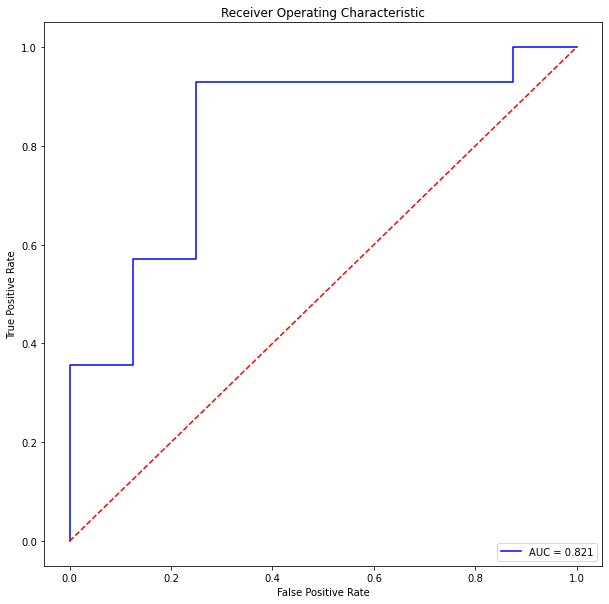

In [15]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

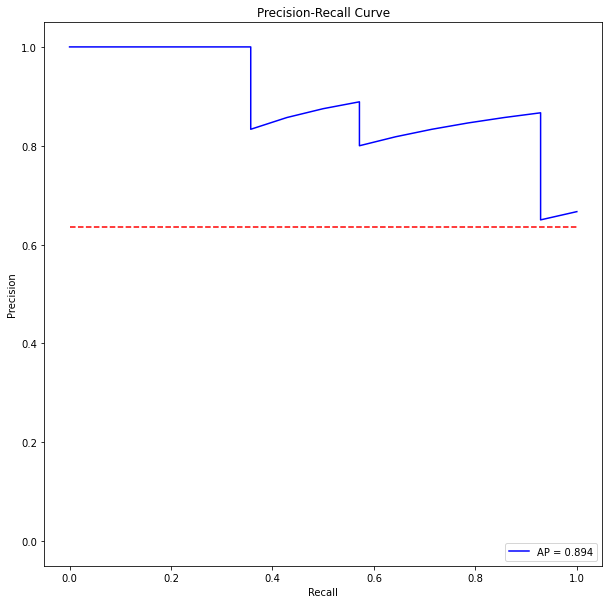

In [16]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

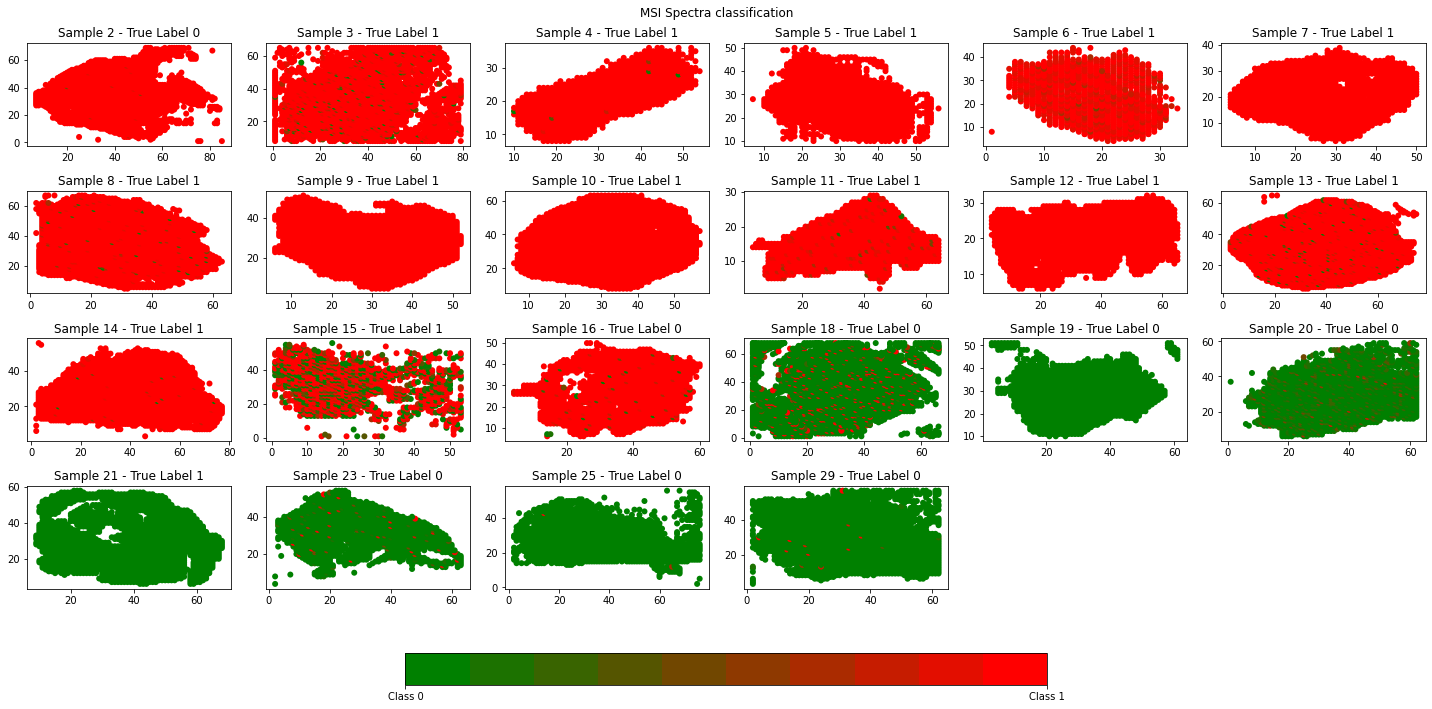

In [17]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [18]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_1/excluded_{exclude_sample}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [02:15<00:00,  6.17s/it]


Next, let's get some statistics about each left out sample predictions:

In [19]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.0000055796,1.0000000000,0.9999488592,0.9860824347,0.1009803712,0,1
1,3,0.0006614663,0.9999992847,0.9990839362,0.9597447515,0.1504074335,1,1
2,4,0.9999939203,1.0000000000,1.0000000000,1.0000000000,0.0000002789,1,1
3,5,0.9999983311,1.0000000000,1.0000000000,1.0000000000,0.0000001656,1,1
4,6,0.0768574998,0.9823158383,0.6253755093,0.6067801118,0.2052274346,1,1
5,7,0.9690299034,0.9999989271,0.9999113083,0.9994393587,0.0016196582,1,1
6,8,0.0000000000,1.0000000000,0.9999992847,0.9544143677,0.1984037161,1,1
7,9,0.9999271631,0.9999989271,0.9999929667,0.9999890924,0.0000097312,1,1
8,10,0.9988229871,0.9999998808,0.9999970198,0.9999883175,0.0000564539,1,1
9,11,0.0009812434,0.9901477695,0.0620423481,0.1781490594,0.2428788394,1,0


Next, let's evaluate the classification performance:

In [20]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.818
Balanced  Accuracy: 0.804
Precision: 0.857
Recall: 0.857
F1 score: 0.857


Next, let's plot the roc curve:

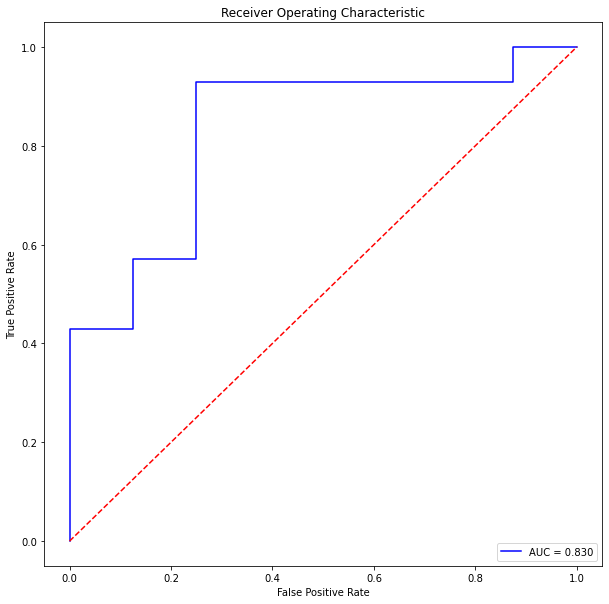

In [21]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

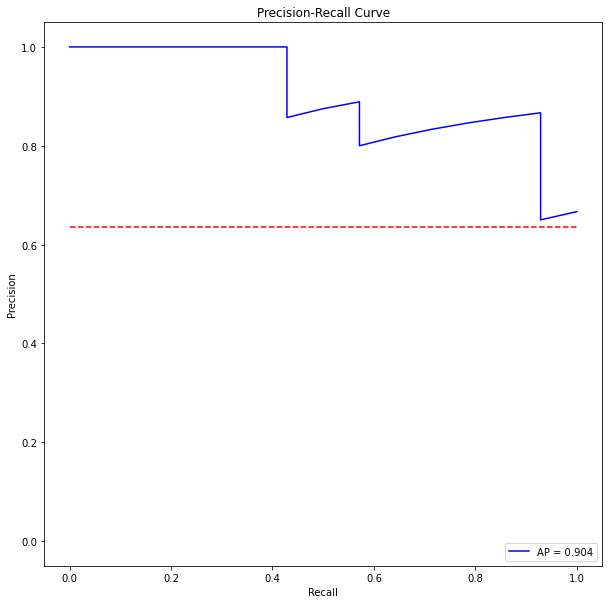

In [22]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

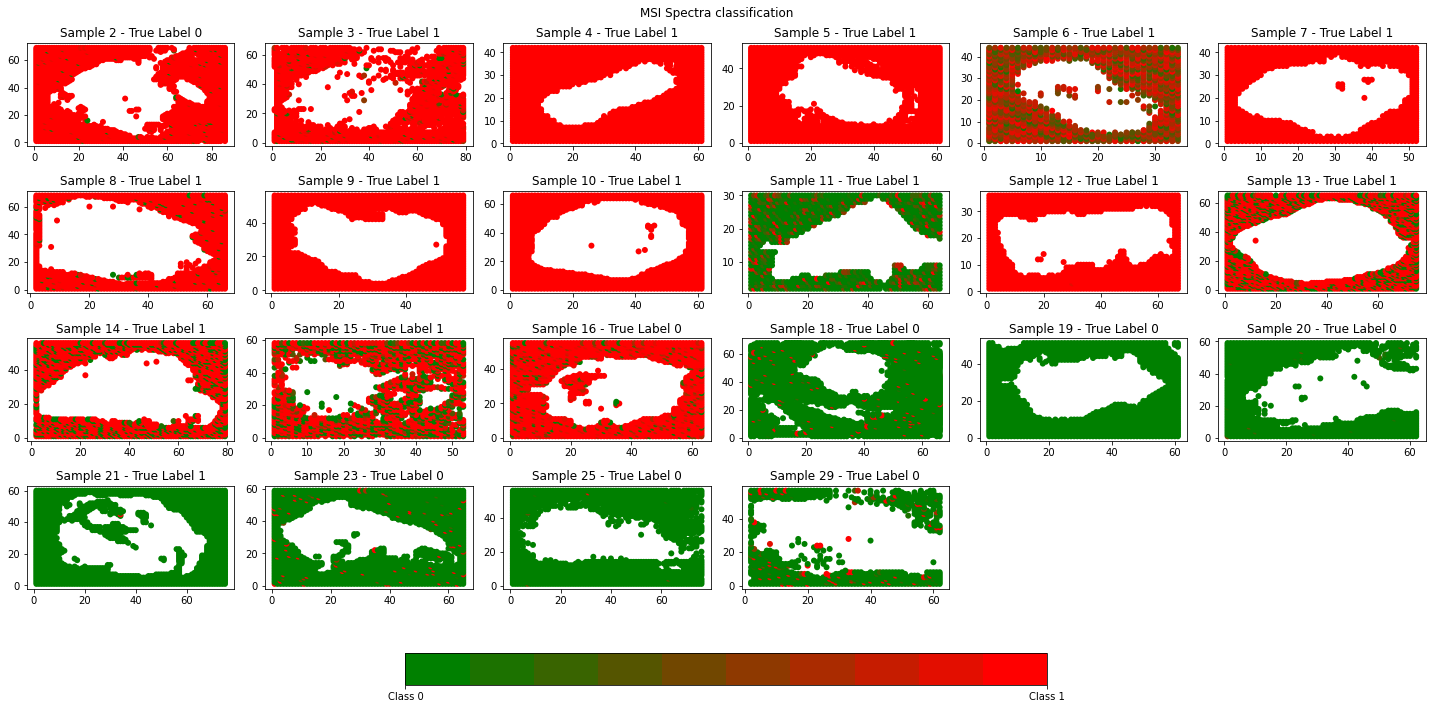

In [23]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Approach 2 - Leave one image out + no standardization:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [24]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_image, group in tqdm(metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them 
  exclude_spectras = np.isin(sample_numbers, group.sample_number.to_list())

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, False)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, False)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_2/excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
128/128 [==============================] - 49s 377ms/step - loss: 0.0566 - binary_accuracy: 0.9780 - val_loss: 0.6822 - val_binary_accuracy: 0.5564
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 12-11-r\assets
Epoch 2/100
128/128 [==============================] - 46s 359ms/step - loss: 0.0056 - binary_accuracy: 0.9985 - val_loss: 0.7244 - val_binary_accuracy: 0.4436
Epoch 3/100
128/128 [==============================] - 44s 343ms/step - loss: 0.0033 - binary_accuracy: 0.9989 - val_loss: 0.4942 - val_binary_accuracy: 0.8041
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 12-11-r\assets
Epoch 4/100
128/128 [==============================] - 50s 390ms/step - loss: 0.0026 - binary_accuracy: 0.9993 - val_loss: 0.1532 - val_binary_accuracy: 0.9901
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 12-11-r\assets
Epoch 5/100
128/128 [==============================] - 47s 364ms/step - loss: 0.0022 - binary_accuracy: 0.9993 - val_loss: 0.0182 - val

 12%|█▎        | 1/8 [09:52<1:09:04, 592.01s/it]

##############################
Epoch 1/100
118/118 [==============================] - 42s 348ms/step - loss: 0.0458 - binary_accuracy: 0.9809 - val_loss: 0.6859 - val_binary_accuracy: 0.5197
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 14-13-r\assets
Epoch 2/100
118/118 [==============================] - 43s 364ms/step - loss: 0.0033 - binary_accuracy: 0.9991 - val_loss: 0.6608 - val_binary_accuracy: 0.5183
Epoch 3/100
118/118 [==============================] - 40s 341ms/step - loss: 0.0022 - binary_accuracy: 0.9992 - val_loss: 0.5098 - val_binary_accuracy: 0.9941
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 14-13-r\assets
Epoch 4/100
118/118 [==============================] - 44s 374ms/step - loss: 8.3989e-04 - binary_accuracy: 0.9998 - val_loss: 0.2121 - val_binary_accuracy: 0.9919
Epoch 5/100
118/118 [==============================] - 41s 347ms/step - loss: 6.9002e-04 - binary_accuracy: 0.9997 - val_loss: 0.0273 - val_binary_accuracy: 0.9951
INFO:tensor

 25%|██▌       | 2/8 [20:57<1:03:30, 635.15s/it]

##############################
Epoch 1/100
126/126 [==============================] - 46s 356ms/step - loss: 0.0435 - binary_accuracy: 0.9831 - val_loss: 0.6671 - val_binary_accuracy: 0.5857
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 16-15-r\assets
Epoch 2/100
126/126 [==============================] - 46s 364ms/step - loss: 0.0034 - binary_accuracy: 0.9991 - val_loss: 0.6615 - val_binary_accuracy: 0.4182
Epoch 3/100
126/126 [==============================] - 44s 349ms/step - loss: 0.0019 - binary_accuracy: 0.9996 - val_loss: 0.4324 - val_binary_accuracy: 0.9956
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 16-15-r\assets
Epoch 4/100
126/126 [==============================] - 46s 369ms/step - loss: 0.0040 - binary_accuracy: 0.9992 - val_loss: 0.3144 - val_binary_accuracy: 0.8571
Epoch 5/100
126/126 [==============================] - 43s 341ms/step - loss: 0.0024 - binary_accuracy: 0.9997 - val_loss: 0.1666 - val_binary_accuracy: 0.9297
Epoch 6/100
126/126

 38%|███▊      | 3/8 [30:20<50:11, 602.40s/it]  

##############################
Epoch 1/100
116/116 [==============================] - 42s 358ms/step - loss: 0.0670 - binary_accuracy: 0.9753 - val_loss: 0.6282 - val_binary_accuracy: 0.6702
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 18-19-18-r\assets
Epoch 2/100
116/116 [==============================] - 45s 387ms/step - loss: 0.0051 - binary_accuracy: 0.9988 - val_loss: 0.5974 - val_binary_accuracy: 0.6702
Epoch 3/100
116/116 [==============================] - 43s 372ms/step - loss: 0.0057 - binary_accuracy: 0.9990 - val_loss: 0.4517 - val_binary_accuracy: 0.7111
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 18-19-18-r\assets
Epoch 4/100
116/116 [==============================] - 42s 359ms/step - loss: 0.0032 - binary_accuracy: 0.9990 - val_loss: 0.6019 - val_binary_accuracy: 0.6626
Epoch 5/100
116/116 [==============================] - 40s 347ms/step - loss: 0.0029 - binary_accuracy: 0.9992 - val_loss: 0.1555 - val_binary_accuracy: 0.9528
INFO:tensorfl

 50%|█████     | 4/8 [41:51<42:29, 637.45s/it]

##############################
Epoch 1/100
103/103 [==============================] - 36s 340ms/step - loss: 0.0673 - binary_accuracy: 0.9779 - val_loss: 0.6155 - val_binary_accuracy: 0.6909
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 29-25-23-21-20-r\assets
Epoch 2/100
103/103 [==============================] - 37s 360ms/step - loss: 0.0035 - binary_accuracy: 0.9992 - val_loss: 0.6319 - val_binary_accuracy: 0.6909
Epoch 3/100
103/103 [==============================] - 35s 341ms/step - loss: 0.0017 - binary_accuracy: 0.9996 - val_loss: 0.6722 - val_binary_accuracy: 0.5370
Epoch 4/100
103/103 [==============================] - 34s 326ms/step - loss: 0.0014 - binary_accuracy: 0.9997 - val_loss: 0.4890 - val_binary_accuracy: 0.9600
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 29-25-23-21-20-r\assets
Epoch 5/100
103/103 [==============================] - 36s 348ms/step - loss: 6.9737e-04 - binary_accuracy: 0.9999 - val_loss: 0.1659 - val_binary_accuracy: 0.99

 62%|██████▎   | 5/8 [51:31<30:49, 616.55s/it]

##############################
Epoch 1/100
127/127 [==============================] - 46s 355ms/step - loss: 0.0457 - binary_accuracy: 0.9806 - val_loss: 0.6845 - val_binary_accuracy: 0.9447
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 6-6-7-r\assets
Epoch 2/100
127/127 [==============================] - 48s 377ms/step - loss: 0.0042 - binary_accuracy: 0.9985 - val_loss: 0.7058 - val_binary_accuracy: 0.4477
Epoch 3/100
127/127 [==============================] - 46s 363ms/step - loss: 0.0037 - binary_accuracy: 0.9990 - val_loss: 0.5842 - val_binary_accuracy: 0.5499
Epoch 4/100
127/127 [==============================] - 46s 359ms/step - loss: 0.0028 - binary_accuracy: 0.9993 - val_loss: 0.3465 - val_binary_accuracy: 0.8058
Epoch 5/100
127/127 [==============================] - 45s 354ms/step - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 0.0039 - val_binary_accuracy: 0.9996
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 6-6-7-r\assets
Epoch 6/100
127/127

 75%|███████▌  | 6/8 [1:01:52<20:36, 618.15s/it]

##############################
Epoch 1/100
102/102 [==============================] - 36s 347ms/step - loss: 0.0497 - binary_accuracy: 0.9814 - val_loss: 0.6845 - val_binary_accuracy: 0.5261
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 8-5-4-3-2-r\assets
Epoch 2/100
102/102 [==============================] - 38s 375ms/step - loss: 0.0044 - binary_accuracy: 0.9983 - val_loss: 0.6618 - val_binary_accuracy: 0.4739
Epoch 3/100
102/102 [==============================] - 34s 329ms/step - loss: 0.0018 - binary_accuracy: 0.9995 - val_loss: 0.5703 - val_binary_accuracy: 0.7626
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 8-5-4-3-2-r\assets
Epoch 4/100
102/102 [==============================] - 38s 369ms/step - loss: 0.0023 - binary_accuracy: 0.9991 - val_loss: 0.3209 - val_binary_accuracy: 0.9994
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 8-5-4-3-2-r\assets
Epoch 5/100
102/102 [==============================] - 40s 392ms/step - loss: 0.0015 - binar

 88%|████████▊ | 7/8 [1:18:19<12:18, 738.66s/it]

##############################
Epoch 1/100
123/123 [==============================] - 44s 350ms/step - loss: 0.0717 - binary_accuracy: 0.9751 - val_loss: 0.6867 - val_binary_accuracy: 0.5384
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 9-10-r\assets
Epoch 2/100
123/123 [==============================] - 49s 402ms/step - loss: 0.0033 - binary_accuracy: 0.9993 - val_loss: 0.6451 - val_binary_accuracy: 0.7968
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 9-10-r\assets
Epoch 3/100
123/123 [==============================] - 45s 368ms/step - loss: 0.0019 - binary_accuracy: 0.9996 - val_loss: 0.4708 - val_binary_accuracy: 0.9224
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 9-10-r\assets
Epoch 4/100
123/123 [==============================] - 45s 363ms/step - loss: 0.0015 - binary_accuracy: 0.9995 - val_loss: 0.3005 - val_binary_accuracy: 0.8399
Epoch 5/100
123/123 [==============================] - 44s 355ms/step - loss: 0.0016 - binary_accuracy: 0.9

100%|██████████| 8/8 [1:26:51<00:00, 651.50s/it]

##############################


In [25]:
train_metrics

{'HG 12-11-r': [0.0001081914160749875, 1.0],
 'HG 14-13-r': [1.6814783521112986e-05, 1.0],
 'HG 16-15-r': [0.00013364391634240746, 1.0],
 'HG 18-19-18-r': [3.286949868197553e-05, 0.9999662041664124],
 'HG 29-25-23-21-20-r': [0.16187530755996704, 0.999846875667572],
 'HG 6-6-7-r': [1.0536097761359997e-05, 1.0],
 'HG 8-5-4-3-2-r': [2.199514938183711e-06, 1.0],
 'HG 9-10-r': [0.008021732792258263, 0.9999362826347351]}

In [26]:
validation_metrics

{'HG 12-11-r': [0.005663370713591576, 0.9996324181556702],
 'HG 14-13-r': [0.0007343669421970844, 0.999733567237854],
 'HG 16-15-r': [0.0019015748985111713, 0.9997503161430359],
 'HG 18-19-18-r': [0.0006210569990798831, 0.9998648166656494],
 'HG 29-25-23-21-20-r': [0.1659116894006729, 0.9990813136100769],
 'HG 6-6-7-r': [0.004019548185169697, 0.9997527599334717],
 'HG 8-5-4-3-2-r': [0.00010601458780001849, 1.0],
 'HG 9-10-r': [0.012994582764804363, 0.9992350935935974]}

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [27]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [02:10<00:00,  5.43s/it]


Next, let's get some statistics about each left out sample predictions:

In [28]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 12-r,0.9977627993,0.9999996424,0.9999653101,0.9999315739,0.0001257618,1,1
1,HG 11-r,0.2398511469,0.9998469353,0.9839921594,0.9645121694,0.0607890673,1,1
2,HG 14-r,0.0000000003,1.0000000000,0.0000036150,0.0095385304,0.0738885328,1,0
3,HG 13-r,0.0000000000,1.0000000000,0.0000000757,0.0032307694,0.0533223003,1,0
4,HG 16-r,0.0336168520,0.9999939203,0.9979500175,0.9387154579,0.1543148011,0,1
5,HG 15-r,0.0493736193,0.9999985695,0.9962068796,0.9601459503,0.1136046126,1,1
6,HG 18_1-r,0.0000000175,1.0000000000,0.6783159971,0.5717208982,0.3876269162,0,1
7,HG 19-r,0.0000000000,0.9999996424,0.3093508780,0.4442397058,0.4079385102,0,0
8,HG 18_2-r,0.0000000001,1.0000000000,0.2158533782,0.3734464943,0.3711240888,0,0
9,HG 29-r,0.0625434369,0.8293051124,0.3659571409,0.3729663789,0.1342243701,0,0


Next, let's evaluate the classification performance:

In [29]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.625
Balanced  Accuracy: 0.656
Precision: 0.800
Recall: 0.533
F1 score: 0.640


Next, let's plot the roc curve:

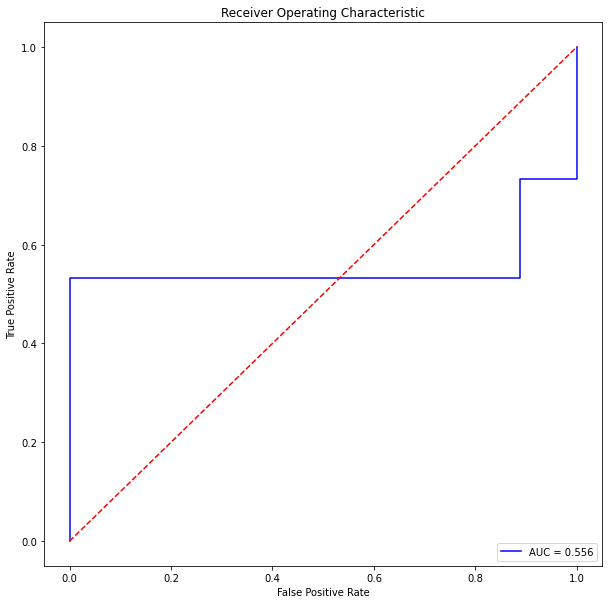

In [30]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

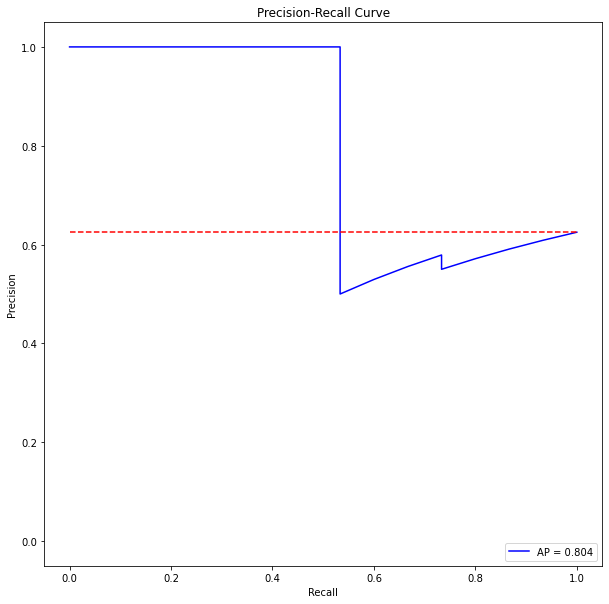

In [31]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

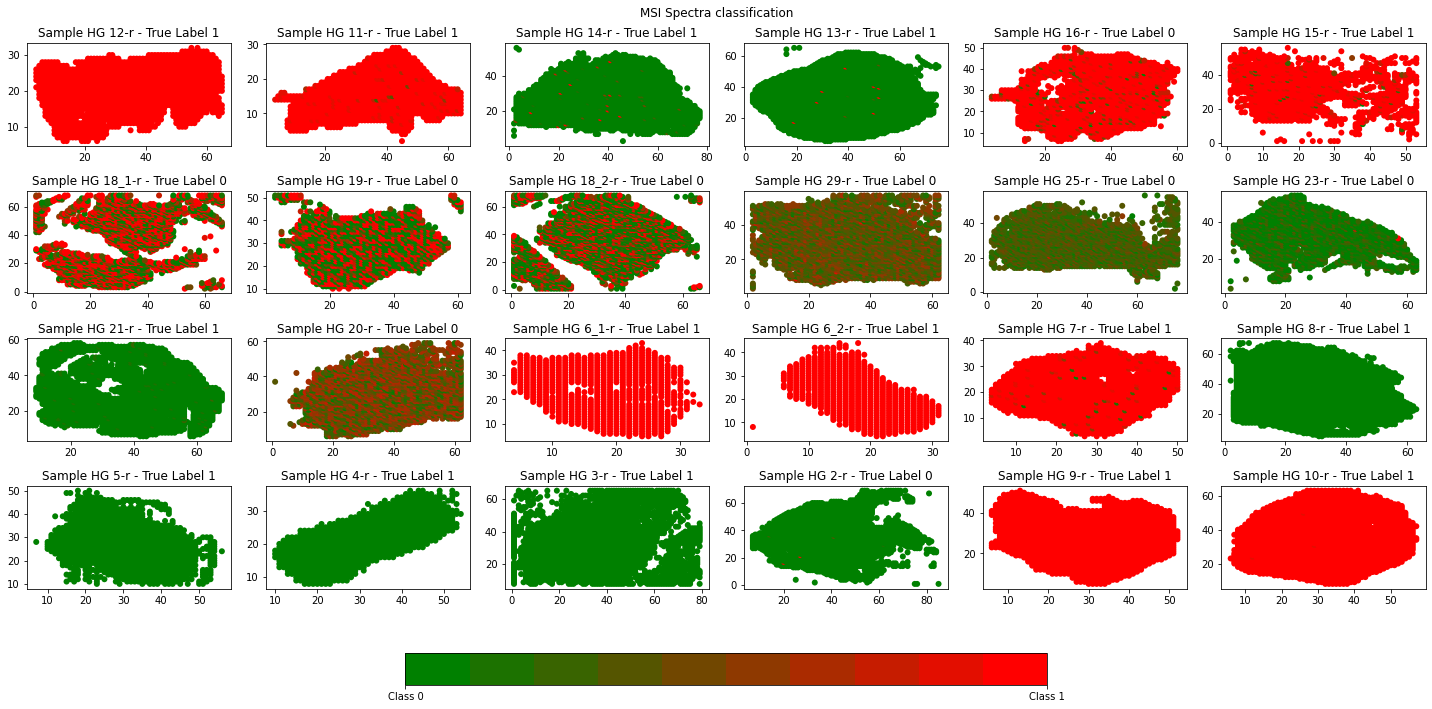

In [32]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & is_tissue],
                  y_coordinates[(file_names == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [33]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [02:13<00:00,  5.55s/it]


Next, let's get some statistics about each left out sample predictions:

In [34]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 12-r,0.9745809436,0.9999760389,0.9987223744,0.9978590012,0.0026731545,1,1
1,HG 11-r,0.7037711143,0.9970492721,0.9689413905,0.9619158506,0.0295182914,1,1
2,HG 14-r,0.0000000000,1.0000000000,0.0003050891,0.1451922059,0.3250573874,1,0
3,HG 13-r,0.0000000000,1.0000000000,0.0000346145,0.2499983162,0.4148500562,1,0
4,HG 16-r,0.0278206002,0.9999997616,0.9980617762,0.8942669034,0.1944303066,0,1
5,HG 15-r,0.1228313074,0.9999972582,0.9974758029,0.9681154490,0.0836585909,1,1
6,HG 18_1-r,0.0000001099,1.0000000000,0.1947711110,0.3840140998,0.3907194734,0,0
7,HG 19-r,0.0000600572,1.0000000000,0.0959302038,0.3370355964,0.4012965262,0,0
8,HG 18_2-r,0.0000000000,1.0000000000,0.1471962929,0.4235410094,0.4441569149,0,0
9,HG 29-r,0.0960258618,0.9222037792,0.4193635881,0.4438394606,0.1200238243,0,0


Next, let's evaluate the classification performance:

In [35]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.625
Balanced  Accuracy: 0.678
Precision: 0.875
Recall: 0.467
F1 score: 0.609


Next, let's plot the roc curve:

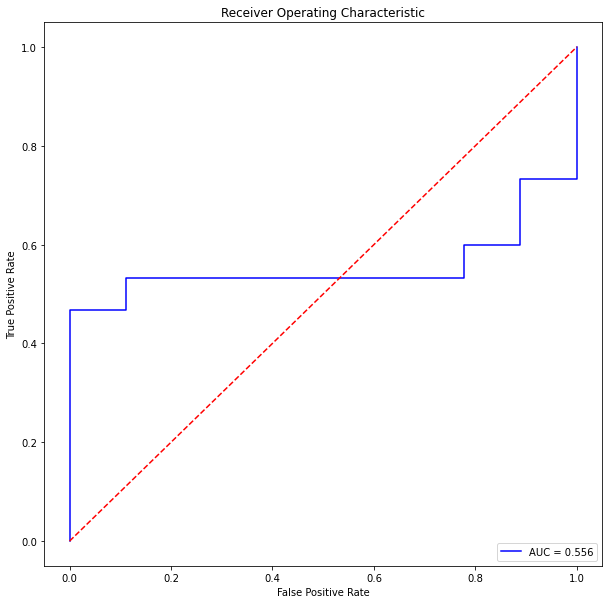

In [36]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

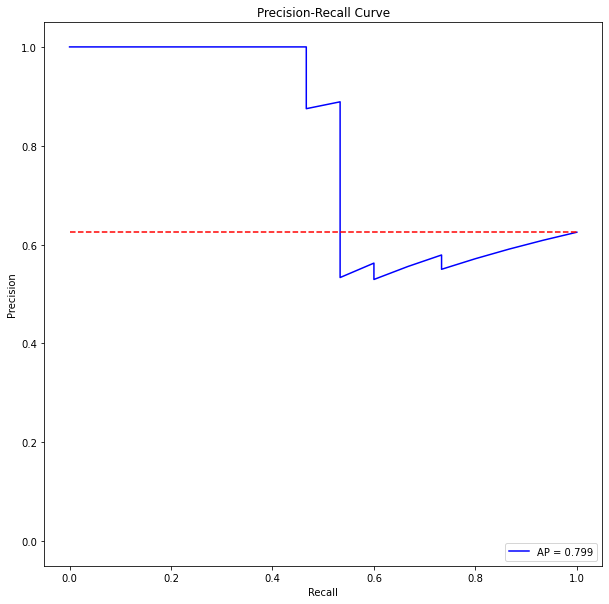

In [37]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

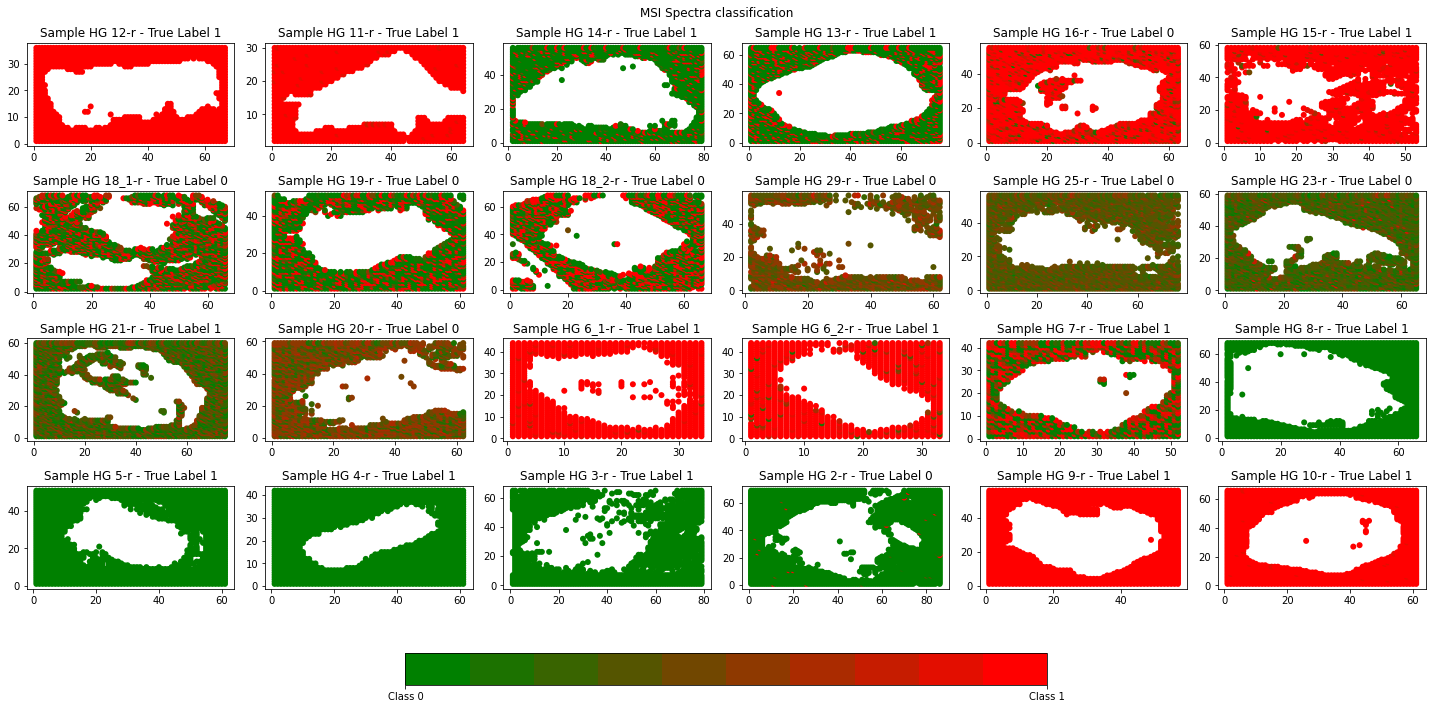

In [38]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & ~is_tissue],
                  y_coordinates[(file_names == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Approach 3 - Leave one image out + standardization:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [39]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_image, group in tqdm(metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them 
  exclude_spectras = np.isin(sample_numbers, group.sample_number.to_list())

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, True)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, True)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_3/excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
128/128 [==============================] - 61s 466ms/step - loss: 0.1178 - binary_accuracy: 0.9558 - val_loss: 0.0428 - val_binary_accuracy: 0.9896
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 12-11-r\assets
Epoch 2/100
128/128 [==============================] - 56s 440ms/step - loss: 0.0186 - binary_accuracy: 0.9936 - val_loss: 0.0392 - val_binary_accuracy: 0.9917
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 12-11-r\assets
Epoch 3/100
128/128 [==============================] - 58s 453ms/step - loss: 0.0102 - binary_accuracy: 0.9968 - val_loss: 0.0400 - val_binary_accuracy: 0.9924
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 12-11-r\assets
Epoch 4/100
128/128 [==============================] - 56s 437ms/step - loss: 0.0087 - binary_accuracy: 0.9972 - val_loss: 0.0342 - val_binary_accuracy: 0.9912
Epoch 5/100
128/128 [==============================] - 54s 418ms/step - loss: 0.0071 - binary_accuracy: 0.9981 - val_loss: 0.0311 - val

 12%|█▎        | 1/8 [10:47<1:15:30, 647.18s/it]

##############################
Epoch 1/100
118/118 [==============================] - 52s 430ms/step - loss: 0.1233 - binary_accuracy: 0.9515 - val_loss: 0.0312 - val_binary_accuracy: 0.9911
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-r\assets
Epoch 2/100
118/118 [==============================] - 52s 441ms/step - loss: 0.0192 - binary_accuracy: 0.9937 - val_loss: 0.0197 - val_binary_accuracy: 0.9935
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-r\assets
Epoch 3/100
118/118 [==============================] - 52s 439ms/step - loss: 0.0102 - binary_accuracy: 0.9965 - val_loss: 0.0321 - val_binary_accuracy: 0.9895
Epoch 4/100
118/118 [==============================] - 54s 455ms/step - loss: 0.0085 - binary_accuracy: 0.9974 - val_loss: 0.0225 - val_binary_accuracy: 0.9925
Epoch 5/100
118/118 [==============================] - 49s 414ms/step - loss: 0.0065 - binary_accuracy: 0.9979 - val_loss: 0.0354 - val_binary_accuracy: 0.9884
Epoch 6/100
118/118

 25%|██▌       | 2/8 [18:03<52:18, 523.16s/it]  

##############################
Epoch 1/100
126/126 [==============================] - 54s 423ms/step - loss: 0.1067 - binary_accuracy: 0.9610 - val_loss: 0.0506 - val_binary_accuracy: 0.9936
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-r\assets
Epoch 2/100
126/126 [==============================] - 60s 472ms/step - loss: 0.0220 - binary_accuracy: 0.9922 - val_loss: 0.0412 - val_binary_accuracy: 0.9933
Epoch 3/100
126/126 [==============================] - 55s 433ms/step - loss: 0.0115 - binary_accuracy: 0.9964 - val_loss: 0.0483 - val_binary_accuracy: 0.9913
Epoch 4/100
126/126 [==============================] - 57s 449ms/step - loss: 0.0076 - binary_accuracy: 0.9977 - val_loss: 0.0263 - val_binary_accuracy: 0.9949
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-r\assets
Epoch 5/100
126/126 [==============================] - 57s 453ms/step - loss: 0.0047 - binary_accuracy: 0.9985 - val_loss: 0.0287 - val_binary_accuracy: 0.9930
Epoch 6/100
126/126

 38%|███▊      | 3/8 [31:28<54:18, 651.74s/it]

##############################
Epoch 1/100
116/116 [==============================] - 50s 420ms/step - loss: 0.1361 - binary_accuracy: 0.9518 - val_loss: 0.0389 - val_binary_accuracy: 0.9874
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 18-19-18-r\assets
Epoch 2/100
116/116 [==============================] - 52s 450ms/step - loss: 0.0206 - binary_accuracy: 0.9929 - val_loss: 0.0220 - val_binary_accuracy: 0.9935
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 18-19-18-r\assets
Epoch 3/100
116/116 [==============================] - 51s 438ms/step - loss: 0.0108 - binary_accuracy: 0.9962 - val_loss: 0.0231 - val_binary_accuracy: 0.9928
Epoch 4/100
116/116 [==============================] - 48s 416ms/step - loss: 0.0080 - binary_accuracy: 0.9972 - val_loss: 0.0250 - val_binary_accuracy: 0.9932
Epoch 5/100
116/116 [==============================] - 53s 456ms/step - loss: 0.0069 - binary_accuracy: 0.9980 - val_loss: 0.0262 - val_binary_accuracy: 0.9935
Epoch 6/100
1

 50%|█████     | 4/8 [38:42<37:42, 565.72s/it]

##############################
Epoch 1/100
103/103 [==============================] - 43s 407ms/step - loss: 0.0935 - binary_accuracy: 0.9660 - val_loss: 0.0435 - val_binary_accuracy: 0.9897
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-r\assets
Epoch 2/100
103/103 [==============================] - 45s 441ms/step - loss: 0.0180 - binary_accuracy: 0.9948 - val_loss: 0.0167 - val_binary_accuracy: 0.9959
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-r\assets
Epoch 3/100
103/103 [==============================] - 43s 415ms/step - loss: 0.0075 - binary_accuracy: 0.9972 - val_loss: 0.0226 - val_binary_accuracy: 0.9943
Epoch 4/100
103/103 [==============================] - 43s 415ms/step - loss: 0.0047 - binary_accuracy: 0.9984 - val_loss: 0.0214 - val_binary_accuracy: 0.9945
Epoch 5/100
103/103 [==============================] - 41s 395ms/step - loss: 0.0090 - binary_accuracy: 0.9976 - val_loss: 0.0208 - val_binary_accuracy: 0.9951
E

 62%|██████▎   | 5/8 [44:58<24:52, 497.58s/it]

##############################
Epoch 1/100
127/127 [==============================] - 54s 421ms/step - loss: 0.1220 - binary_accuracy: 0.9544 - val_loss: 0.0581 - val_binary_accuracy: 0.9913
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-6-7-r\assets
Epoch 2/100
127/127 [==============================] - 58s 453ms/step - loss: 0.0183 - binary_accuracy: 0.9938 - val_loss: 0.0433 - val_binary_accuracy: 0.9921
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-6-7-r\assets
Epoch 3/100
127/127 [==============================] - 57s 448ms/step - loss: 0.0104 - binary_accuracy: 0.9969 - val_loss: 0.0391 - val_binary_accuracy: 0.9918
Epoch 4/100
127/127 [==============================] - 54s 429ms/step - loss: 0.0082 - binary_accuracy: 0.9972 - val_loss: 0.0292 - val_binary_accuracy: 0.9918
Epoch 5/100
127/127 [==============================] - 54s 424ms/step - loss: 0.0067 - binary_accuracy: 0.9978 - val_loss: 0.0296 - val_binary_accuracy: 0.9943
INFO:tensorflow:Ass

 75%|███████▌  | 6/8 [54:39<17:31, 525.87s/it]

##############################
Epoch 1/100
102/102 [==============================] - 43s 418ms/step - loss: 0.0899 - binary_accuracy: 0.9691 - val_loss: 0.0181 - val_binary_accuracy: 0.9942
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-5-4-3-2-r\assets
Epoch 2/100
102/102 [==============================] - 44s 430ms/step - loss: 0.0153 - binary_accuracy: 0.9955 - val_loss: 0.0169 - val_binary_accuracy: 0.9942
Epoch 3/100
102/102 [==============================] - 42s 415ms/step - loss: 0.0067 - binary_accuracy: 0.9975 - val_loss: 0.0105 - val_binary_accuracy: 0.9969
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-5-4-3-2-r\assets
Epoch 4/100
102/102 [==============================] - 46s 447ms/step - loss: 0.0060 - binary_accuracy: 0.9981 - val_loss: 0.0132 - val_binary_accuracy: 0.9954
Epoch 5/100
102/102 [==============================] - 44s 435ms/step - loss: 0.0035 - binary_accuracy: 0.9989 - val_loss: 0.0097 - val_binary_accuracy: 0.9954
Epoch 6/100

 88%|████████▊ | 7/8 [1:04:19<09:03, 543.57s/it]

##############################
Epoch 1/100
123/123 [==============================] - 55s 442ms/step - loss: 0.1251 - binary_accuracy: 0.9542 - val_loss: 0.0462 - val_binary_accuracy: 0.9906
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-r\assets
Epoch 2/100
123/123 [==============================] - 56s 458ms/step - loss: 0.0188 - binary_accuracy: 0.9940 - val_loss: 0.0205 - val_binary_accuracy: 0.9938
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-r\assets
Epoch 3/100
123/123 [==============================] - 55s 448ms/step - loss: 0.0088 - binary_accuracy: 0.9969 - val_loss: 0.0265 - val_binary_accuracy: 0.9927
Epoch 4/100
123/123 [==============================] - 54s 440ms/step - loss: 0.0067 - binary_accuracy: 0.9976 - val_loss: 0.0226 - val_binary_accuracy: 0.9940
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-r\assets
Epoch 5/100
123/123 [==============================] - 57s 457ms/step - loss: 0.0069 - binary_accuracy: 0.9

100%|██████████| 8/8 [1:12:07<00:00, 540.94s/it]

##############################


In [40]:
train_metrics

{'HG 12-11-r': [0.00023795216111466289, 1.0],
 'HG 14-13-r': [0.0018154139397665858, 0.9994670152664185],
 'HG 16-15-r': [0.00020033071632497013, 0.9999687671661377],
 'HG 18-19-18-r': [0.001766032655723393, 0.9998986124992371],
 'HG 29-25-23-21-20-r': [0.000609947310294956, 0.9999617338180542],
 'HG 6-6-7-r': [0.0001483293017372489, 1.0],
 'HG 8-5-4-3-2-r': [1.9993294699816033e-05, 1.0],
 'HG 9-10-r': [0.00017628088244237006, 1.0]}

In [41]:
validation_metrics

{'HG 12-11-r': [0.031117480248212814, 0.9925263524055481],
 'HG 14-13-r': [0.019674206152558327, 0.9934718608856201],
 'HG 16-15-r': [0.020666558295488358, 0.9957558512687683],
 'HG 18-19-18-r': [0.022803490981459618, 0.993782103061676],
 'HG 29-25-23-21-20-r': [0.017672495916485786, 0.9960190057754517],
 'HG 6-6-7-r': [0.02958427555859089, 0.9943139553070068],
 'HG 8-5-4-3-2-r': [0.008421782404184341, 0.9973878264427185],
 'HG 9-10-r': [0.02260011062026024, 0.9940081834793091]}

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [42]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, True)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [02:20<00:00,  5.85s/it]


Next, let's get some statistics about each left out sample predictions:

In [43]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 12-r,0.0000000000,1.0000000000,1.0000000000,0.9430962205,0.2316586375,1,1
1,HG 11-r,0.0000000000,1.0000000000,1.0000000000,0.8706411719,0.3355966806,1,1
2,HG 14-r,0.0000000000,1.0000000000,1.0000000000,0.8763636351,0.3291662633,1,1
3,HG 13-r,0.0000000000,1.0000000000,0.0000000000,0.4944636822,0.4999693632,1,0
4,HG 16-r,0.0000000000,1.0000000000,1.0000000000,0.9595758915,0.1969518065,0,1
5,HG 15-r,0.0000000000,1.0000000000,1.0000000000,0.5971387029,0.4904731512,1,1
6,HG 18_1-r,0.0000000000,1.0000000000,0.0000000000,0.3190066814,0.4660916030,0,0
7,HG 19-r,0.0000000000,1.0000000000,0.0000000000,0.2452253699,0.4302207530,0,0
8,HG 18_2-r,0.0000000000,1.0000000000,1.0000000000,0.5654253960,0.4957002401,0,1
9,HG 29-r,0.0000000000,1.0000000000,0.0000000000,0.0075878594,0.0867772102,0,0


Next, let's evaluate the classification performance:

In [44]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.750
Balanced  Accuracy: 0.733
Precision: 0.800
Recall: 0.800
F1 score: 0.800


Next, let's plot the roc curve:

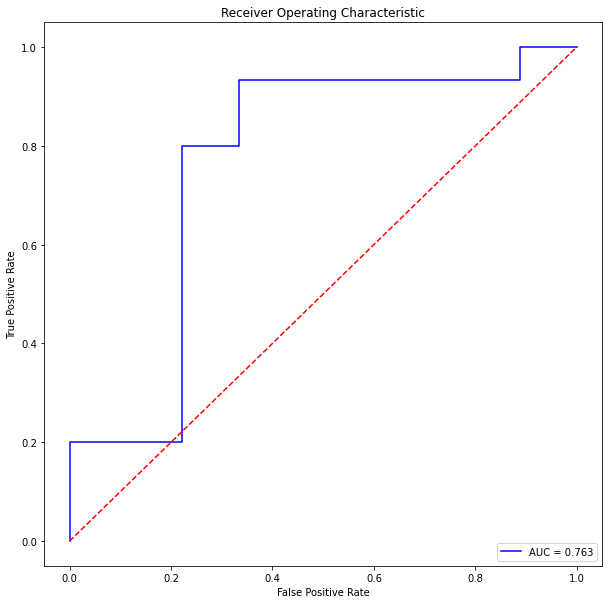

In [45]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

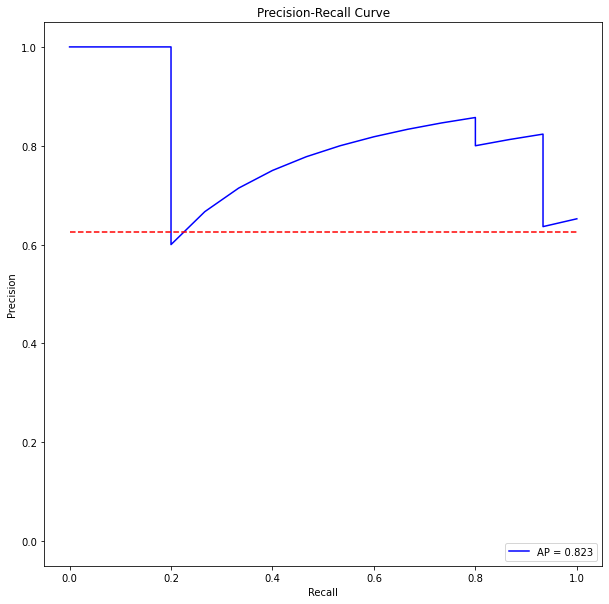

In [46]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

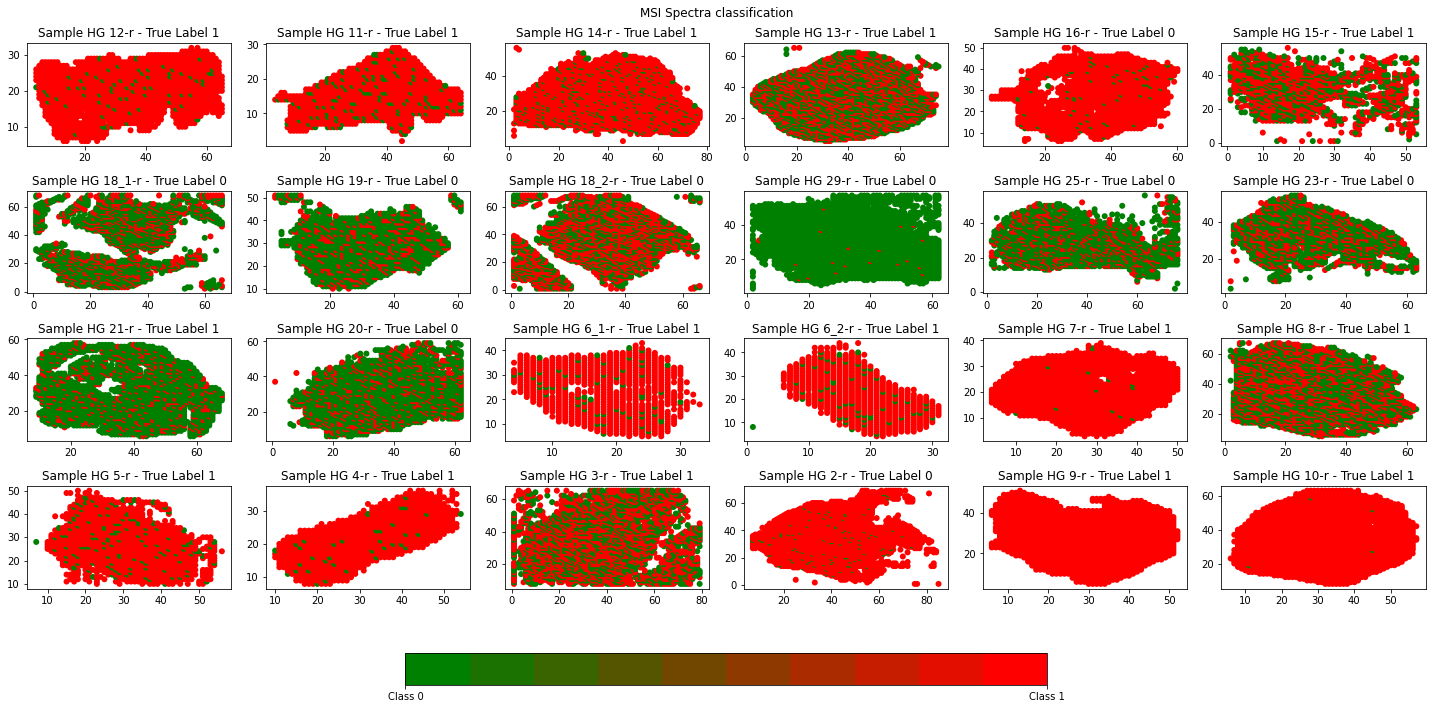

In [47]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & is_tissue],
                  y_coordinates[(file_names == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [48]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [02:12<00:00,  5.53s/it]


Next, let's get some statistics about each left out sample predictions:

In [49]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 12-r,0.9745802879,0.9999760389,0.9987223744,0.9978590012,0.0026731626,1,1
1,HG 11-r,0.7037711143,0.9970492721,0.9689413905,0.9619158506,0.0295183174,1,1
2,HG 14-r,0.0000000000,1.0000000000,0.0003050891,0.1451927871,0.3250578642,1,0
3,HG 13-r,0.0000000000,1.0000000000,0.0000346145,0.2499982566,0.4148500264,1,0
4,HG 16-r,0.0278206002,0.9999997616,0.9980617762,0.8942669034,0.1944302469,0,1
5,HG 15-r,0.1228313074,0.9999972582,0.9974755645,0.9681154490,0.0836587697,1,1
6,HG 18_1-r,0.0000001099,1.0000000000,0.1947711110,0.3840132356,0.3907189369,0,0
7,HG 19-r,0.0000600572,1.0000000000,0.0959302038,0.3370359242,0.4012969732,0,0
8,HG 18_2-r,0.0000000000,1.0000000000,0.1471962929,0.4235410988,0.4441569149,0,0
9,HG 29-r,0.0960258618,0.9222037792,0.4193675220,0.4438394308,0.1200238392,0,0


Next, let's evaluate the classification performance:

In [50]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.625
Balanced  Accuracy: 0.678
Precision: 0.875
Recall: 0.467
F1 score: 0.609


Next, let's plot the roc curve:

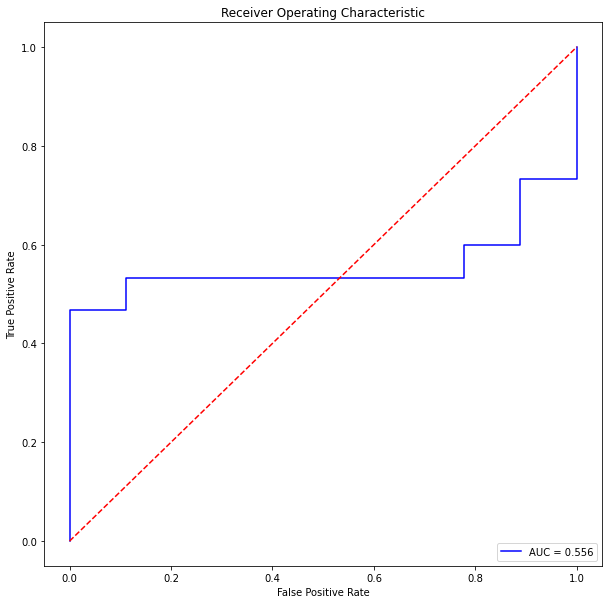

In [51]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

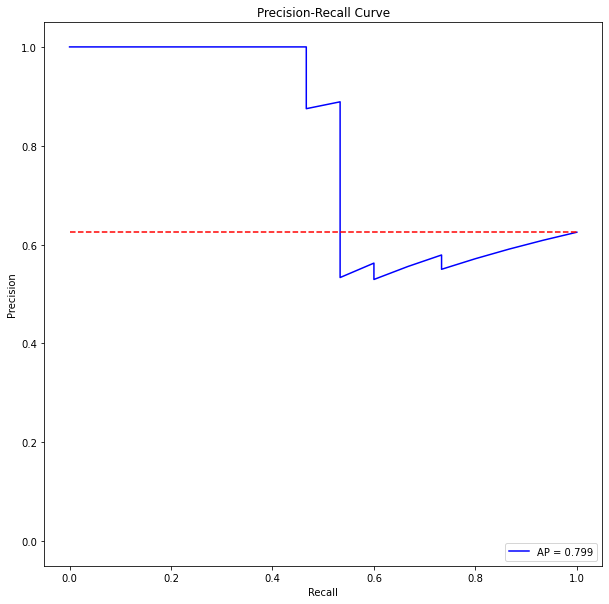

In [52]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

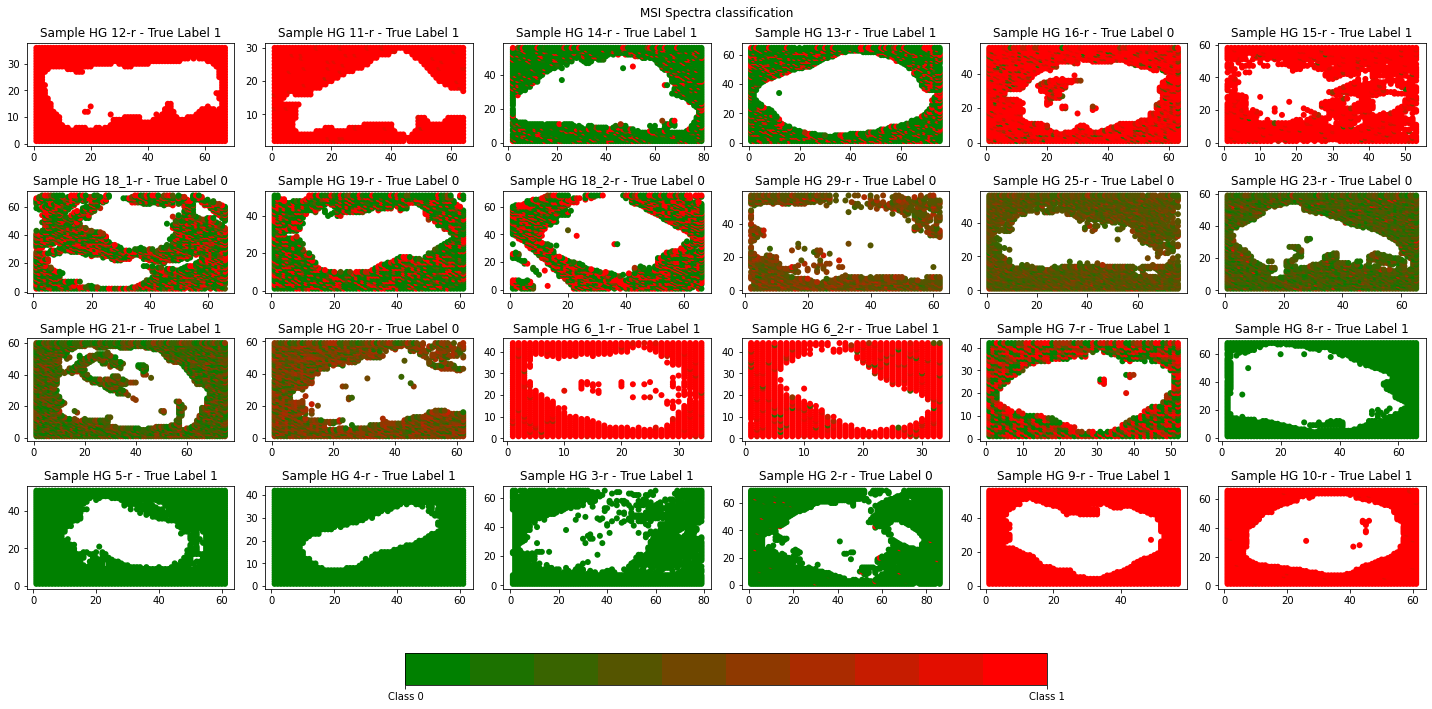

In [53]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & ~is_tissue],
                  y_coordinates[(file_names == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [54]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()